 # Variational quantum circuit tutorial

In [1]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
from collections import namedtuple
from functools import reduce


 ## Variational Quantum Circuit Simulator

In [2]:
# Configuration
Instruction = namedtuple("Instruction", "gate bits symbols")
ket0, ket1 = np.array([1, 0]), np.array([0, 1])
levicivita = np.array([[1, -1], [-1, 1]])


def simulate_shots(psi, n_shots):
    probs = np.conjugate(psi) * psi
    counts = np.floor(np.real(probs * n_shots))
    non_zero_ind = np.where(counts > 0)
    results = {}
    for k in range(len(non_zero_ind[0])):
        index = tuple(ind[k] for ind in non_zero_ind)
        results[index] = counts[index]
    return results


def variational_quantum_simulator(program, nq, initial_qubits=None, symbols=None):
    if initial_qubits is None:
        initial_qubits = [ket0] * nq
    state = initial_qubits[0]
    for qubit in initial_qubits[1:]:
        state = np.array(np.kron(state, qubit))
    state = state.reshape([2 for i in range(nq)])
    for instruction in program:
        u = instruction.gate
        bits = instruction.bits
        instruction_symbols = instruction.symbols
        if len(u.shape) == 2:
            # if u is provided as a matrix, we turn it into the correct tensor
            n_inputs = len(bits)
            idx_range = int(
                u.shape[0] ** (1 / n_inputs)
            )  # matrix is square so we can take first or second axis
            if isinstance(u, sp.Matrix):
                # convert to numpy matrix
                f = sp.lambdify(list(u.free_symbols), u, "numpy")
                u = f(*[symbols[symbol] for symbol in instruction_symbols])
            u = u.reshape([idx_range for i in range(n_inputs * 2)])
        state = np.tensordot(state, u, axes=[bits, [i for i in range(len(bits))]])
        # tensordot reorders the tensor to uncontracted+contracted and we want the original, so we undo their reording:
        current_order = [bit for bit in range(nq) if bit not in bits] + bits
        state = state.transpose([current_order.index(i) for i in range(nq)])
    return state



 ### Gate primitives

In [3]:
# Operations
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
CN = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
x0 = sp.symbols("θ")
Rs = lambda u: sp.cos(x0 / 2) * sp.eye(2) - sp.I * sp.sin(x0 / 2) * u

In [10]:
nq = 4
initial_qubits = [ket0] * nq
x0 = sp.symbols("x0")
x1 = sp.symbols("x1")
symbol_list = [x0, x1]
symbol_vals = [.2,.5]
symbols = {symbol_list[i]: symbol_vals[i] for i in range(len(symbol_vals))}
symbols

{x0: 0.2, x1: 0.5}

In [12]:
instruction1 = Instruction(Rs(X), [0], [x0])
instruction2 = Instruction(Rs(Y), [3], [x1])
program = [instruction1, instruction2]

psi = variational_quantum_simulator(program, nq, initial_qubits, symbols)
psi.flatten()


array([ 0.9640719 +0.j        , -0.24616797+0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        -0.09672984j,  0.        +0.02469918j,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

 ### Quantum programming

In [4]:
instruction1 = Instruction(X, [0], None)
instruction2 = Instruction(X, [3], None)
instruction3 = Instruction(CN, [3, 0], None)
program1 = [instruction1, instruction2]
program2 = [instruction1, instruction2, instruction3]


nq = 5
initial_qubits = [ket0] * nq
psi = variational_quantum_simulator(program1, nq, initial_qubits)
print(np.where(psi == 1))

nq = 5
initial_qubits = [ket0] * nq
psi = variational_quantum_simulator(program2, nq, initial_qubits)
print(np.where(psi == 1))


(array([1]), array([0]), array([0]), array([1]), array([0]))
(array([0]), array([0]), array([0]), array([1]), array([0]))


 ## Variational Quantum Eigensolver

 ### The transverse field Ising model

 ### Circuit ansatz

In [5]:
symbol_list = sp.symbols("x0:3")
instruction1 = Instruction(Rs(Y), [0], [symbol_list[0]])
instruction2 = Instruction(Rs(Z), [0], [symbol_list[1]])
instruction3 = reduce(
    lambda x, y: x + y, [[Instruction(CN, [k, k + 1], None)] for k in range(nq - 1)]
)
instruction4 = reduce(
    lambda x, y: x + y, [[Instruction(Rs(Y), [k], [symbol_list[2]])] for k in range(nq)]
)
instruction5 = reduce(
    lambda x, y: x + y, [[Instruction(H, [k], None)] for k in range(nq)]
)
program_zz = [instruction1, instruction2, *instruction3, *instruction4]
program_x = [instruction1, instruction2, *instruction3, *instruction4, *instruction5]



 ### Objective function

In [6]:
def objective_function(symbols_vals, h, J=1, n_shots=1000):
    symbols = {symbol_list[i]: symbols_vals[i] for i in range(len(symbols_vals))}
    psi_zz = variational_quantum_simulator(program_zz, nq, symbols=symbols)
    psi_x = variational_quantum_simulator(program_x, nq, symbols=symbols)
    get_shots_zz = simulate_shots(psi_zz, n_shots)
    get_shots_x = simulate_shots(psi_x, n_shots)
    sum_zz = 0
    sum_x = 0
    for i in range(nq):
        sum_zz += np.sum(
            [(-1) ** (k[i] ^ k[(i + 1) % 2]) * v for k, v in get_shots_zz.items()]
        )
        sum_x += np.sum([(-1) ** k[i] * v for k, v in get_shots_x.items()])
    exp_zz = sum_zz / n_shots
    exp_x = sum_x / n_shots
    ising_e = J * (-1 / 4) * exp_zz
    tansverse_e = h * (-1 / 2) * exp_x
    return ising_e + tansverse_e



 ### Optimisation

In [7]:
h_vals = np.arange(0.01, 2.2, 0.2)
results_site = []
for h in h_vals:
    tmp_results = []
    for rep in range(10):
        symbol_vals = 2 * np.pi * np.random.uniform(size=3)
        result = sc.optimize.minimize(
            objective_function,
            symbol_vals,
            args=(h),
            method="COBYLA",
            options={"maxiter": 20},
        )
        tmp_results.append(result.fun)
    results_site.append(np.min(tmp_results) / nq)
    print(np.min(tmp_results) / nq)


-0.24985
-0.26083
-0.292075
-0.343555
-0.41406
-0.504995
-0.6048950000000002
-0.7047950000000001
-0.804695
-0.9045950000000001
-1.004495


 ### Visualisation

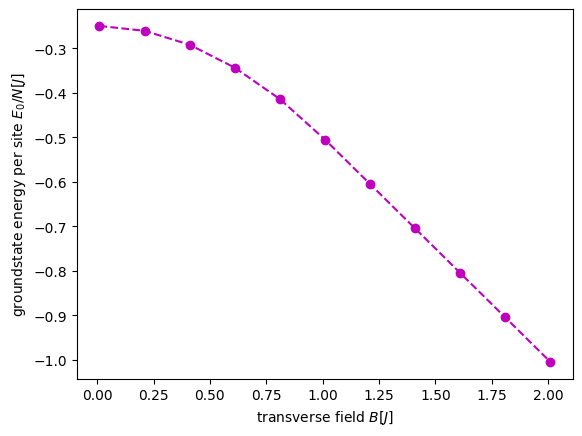

Optimal avg energy: -5.018725
Optimal angles: [-0.02043719  4.9856286   4.71364875]
Optimal avg energy per site: -1.0037449999999999


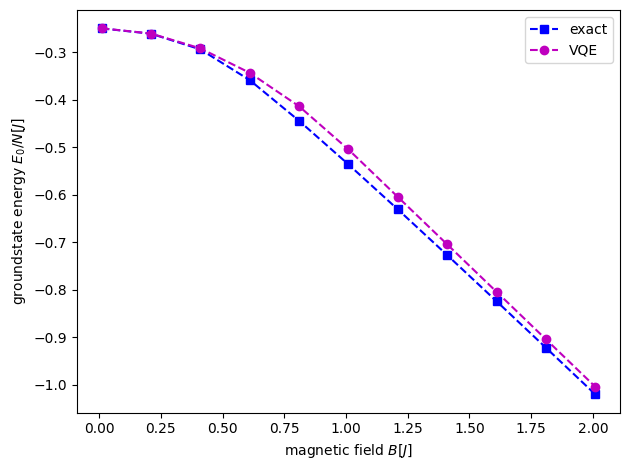

In [8]:
plt.plot(h_vals, results_site, "m--o")
plt.xlabel("transverse field $B [J]$")
plt.ylabel("groundstate energy per site $E_{0}/N [J]$")
plt.show()

print("Optimal avg energy:", result.fun)
print("Optimal angles:", result.x)
print("Optimal avg energy per site:", result.fun / nq)


def num_integrate_gs(B):
    """
    numerically integrate exact band to get gs energy of TIM
    this should give -E_0/(N*J) by Pfeufy
    Here set J=1 (units of energy)
    """
    # lamba_ratio (setting J=1): compare thesis
    ll = 1 / (2 * B)

    # set energy
    gs_energy = 0

    # numerical integration
    step_size = 0.0001
    k_values = np.arange(0, np.pi, step_size)
    integration_values = [
        step_size * np.sqrt(1 + ll**2 + 2 * ll * np.cos(kk)) for kk in k_values
    ]
    integral = np.sum(integration_values)
    gs_energy = 1 * integral / (4 * np.pi * ll)

    return gs_energy


# plot exact gs energy of TIM vs VQE results
x = np.arange(0.01, 2.2, 0.2)
y = [-1 * num_integrate_gs(xx) for xx in x]
# plot exact results
plt.plot(x, y, "b--s", label="exact")
# plot vqe results
plt.plot(h_vals, results_site, "m--o", label="VQE")
plt.xlabel("magnetic field $B [J]$")
plt.ylabel("groundstate energy $E_{0}/N [J]$")
plt.tight_layout()
plt.legend()
